Name: Satyam Mahesh Munot | CWID: 20033002 | Subgroup1

## **Bankruptcy Prediction – Summary**

### **1. Dataset Overview**

* Total rows: **1636**, features: **97**, no missing or duplicate values.
* Class imbalance is extreme: **1608 non-bankrupt vs 28 bankrupt (1.7%)**.
* Standard accuracy is misleading, so imbalance-aware metrics are required.

---

### **2. Feature Insights**

* Violin plots show strong differences in leverage and profitability between classes.
* Bankrupt firms have **higher debt ratios** and **lower profitability**.
* Selected **7 key features** all relate to solvency and leverage (e.g., Borrowing dependency, Liability to Equity, Debt ratio %).

---

### **3. Model Selection**

* All 3-model stacking combinations were tested using **recall(1)** and **balanced accuracy**.
* Best model: **(RandomForest, AdaBoost, Bagging)** with **recall(1) = 1.0**.
* Chosen because it detects **every bankrupt company** while maximizing balanced accuracy.

---

### **4. Final Results**

**Validation Confusion Matrix:**
`[[259, 63], [0, 6]]` → **No bankrupt case missed.**

**Full Data Confusion Matrix:**
`[[1247, 361], [0, 28]]`

* **TT/(TT+TF) = 1.0** → Perfect bankruptcy detection.
* **Overall accuracy ≈ 0.81** due to false positives, expected from a recall-optimized model.
* This trade-off is appropriate because **missing a bankrupt company is far more costly than false alarms**.


In [ ]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from itertools import combinations

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    HistGradientBoostingClassifier,
    StackingClassifier
)

from sklearn.base import clone
from sklearn.metrics import classification_report, confusion_matrix
import joblib

from sklearn.metrics import balanced_accuracy_score


RANDOM_STATE = 42

In [ ]:
df = pd.read_csv("artifacts/cluster_1_train.csv", index_col=0)

print("Shape:", df.shape)
print("\nBankruptcy counts:")
print(df["Bankrupt?"].value_counts())

Shape: (1636, 97)

Bankruptcy counts:
Bankrupt?
0    1608
1      28
Name: count, dtype: int64


   rows  columns  duplicate_rows  bankrupt_n  non_bankrupt_n  bankrupt_%  \
0  1636       97               0          28            1608        1.71   

   non_bankrupt_%  
0           98.29  


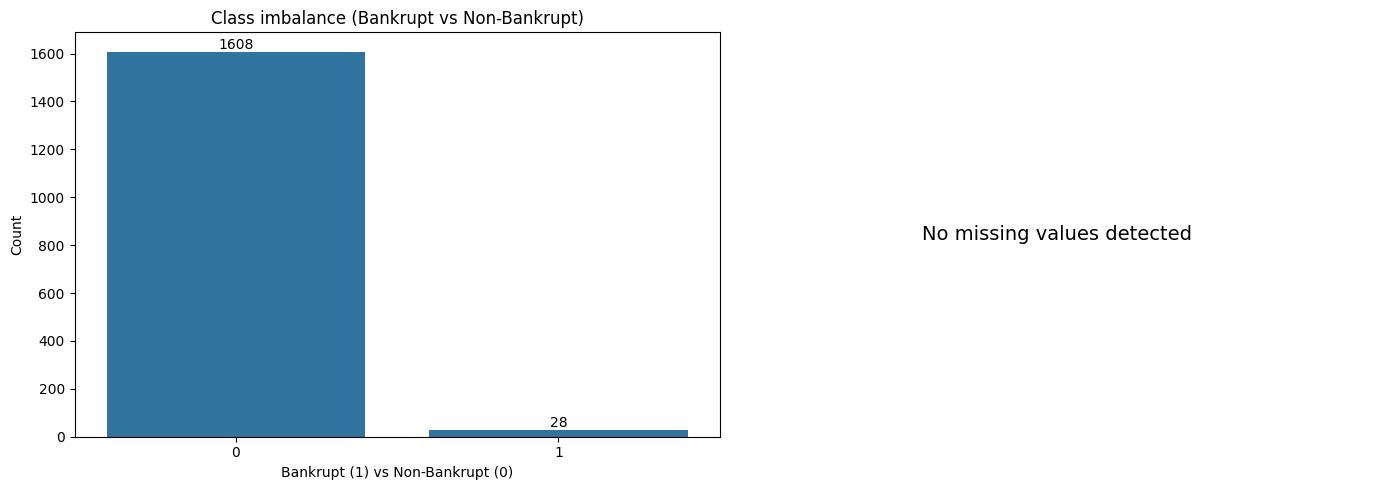

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

target_col = "Bankrupt?" if "Bankrupt?" in df.columns else next((c for c in df.columns if "bankrupt" in c.lower()), None)
y_vis = df[target_col].astype(int)

n_rows, n_cols = df.shape
dup_rows = int(df.duplicated().sum())
missing_rate = (df.isna().mean().sort_values(ascending=False) * 100).round(2)
missing_nonzero = missing_rate[missing_rate > 0]

class_counts = y_vis.value_counts().sort_index()
class_perc = (class_counts / class_counts.sum() * 100).round(2)

print(pd.DataFrame({
    "rows": [n_rows],
    "columns": [n_cols],
    "duplicate_rows": [dup_rows],
    "bankrupt_n": [int(class_counts.get(1, 0))],
    "non_bankrupt_n": [int(class_counts.get(0, 0))],
    "bankrupt_%": [float(class_perc.get(1, 0.0))],
    "non_bankrupt_%": [float(class_perc.get(0, 0.0))]
}))

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x=y_vis, ax=ax[0])
ax[0].set_title("Class imbalance (Bankrupt vs Non-Bankrupt)")
ax[0].set_xlabel("Bankrupt (1) vs Non-Bankrupt (0)")
ax[0].set_ylabel("Count")
for p in ax[0].patches:
    ax[0].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width()/2, p.get_height()), ha="center", va="bottom", fontsize=10)

if len(missing_nonzero) == 0:
    ax[1].axis("off")
    ax[1].text(0.5, 0.5, "No missing values detected", ha="center", va="center", fontsize=14)
else:
    topk = min(25, len(missing_nonzero))
    sns.barplot(x=missing_nonzero.head(topk).values, y=missing_nonzero.head(topk).index, ax=ax[1])
    ax[1].set_title(f"Missingness (%), top {topk} columns")
    ax[1].set_xlabel("Missing (%)")
    ax[1].set_ylabel("")

plt.tight_layout()
plt.show()


The dataset shows a severe class imbalance, with 1,608 non-bankrupt companies compared to only 28 bankrupt cases. This imbalance means the model could easily achieve high accuracy by predicting all samples as non-bankrupt, making standard accuracy misleading. Since bankrupt cases are extremely rare, specialized handling—such as resampling or adjusted evaluation metrics—is essential. Additionally, no missing values were detected, ensuring clean input data for modeling.

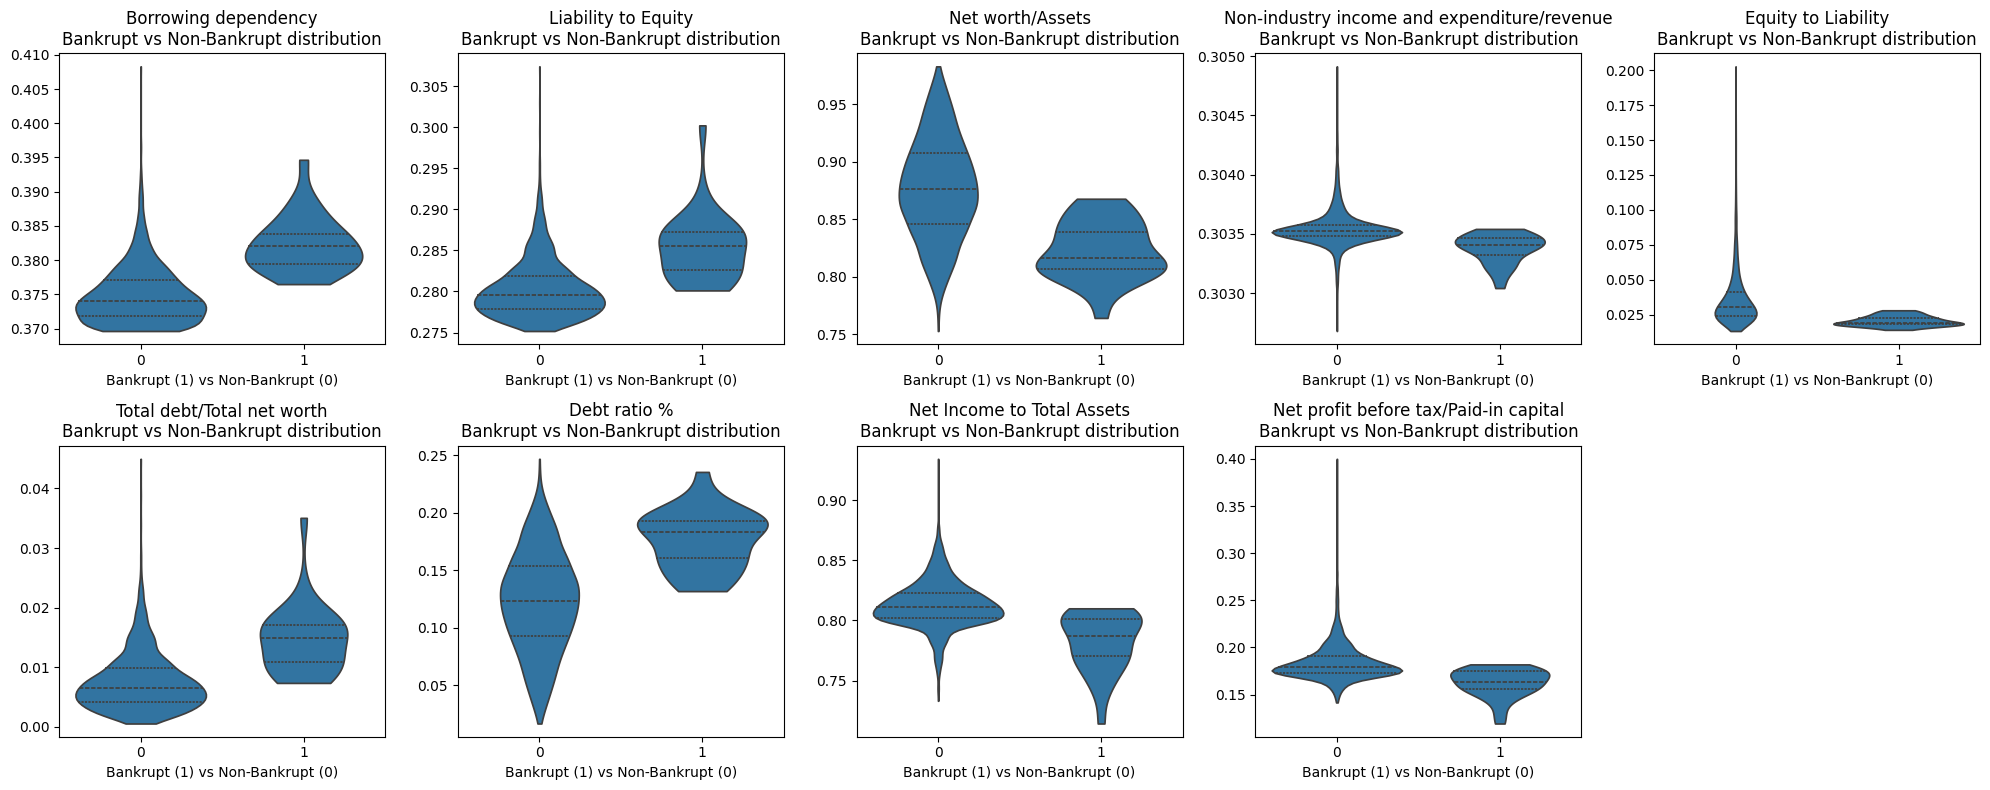

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

target_col = "Bankrupt?" if "Bankrupt?" in df.columns else next((c for c in df.columns if "bankrupt" in c.lower()), None)
y_vis = df[target_col].astype(int)

num_df = df.select_dtypes(include=[np.number]).copy()
X_num = num_df.drop(columns=[target_col], errors="ignore")
if "Index" in X_num.columns:
    X_num = X_num.drop(columns=["Index"], errors="ignore")
X_num = X_num.replace([np.inf, -np.inf], np.nan)

mask0 = (y_vis == 0)
mask1 = (y_vis == 1)

feat_list = [
    "Borrowing dependency",
    "Liability to Equity",
    "Net worth/Assets",
    "Non-industry income and expenditure/revenue",
    "Equity to Liability",
    "Total debt/Total net worth",
    "Debt ratio %",
    "Net Income to Total Assets",
    "ROA(C) before interest and depreciation before...",
    "Net profit before tax/Paid-in capital"
]

feat_list = [f for f in feat_list if f in X_num.columns]

plot_df = pd.concat([y_vis.rename(target_col), X_num[feat_list]], axis=1)
plot_df = plot_df.dropna(subset=feat_list, how="all")

rows, cols = 2, 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
axes = axes.flatten()

for i, f in enumerate(feat_list):
    ax = axes[i]
    tmp = plot_df[[target_col, f]].dropna()
    sns.violinplot(data=tmp, x=target_col, y=f, inner="quartile", cut=0, ax=ax)
    ax.set_title(f"{f}\nBankrupt vs Non-Bankrupt distribution")
    ax.set_xlabel("Bankrupt (1) vs Non-Bankrupt (0)")
    ax.set_ylabel("")

for j in range(len(feat_list), rows * cols):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


The violin plots highlight clear distributional differences between bankrupt and non-bankrupt companies across the top financial ratios. Bankrupt firms consistently show higher leverage indicators such as Borrowing Dependency, Debt Ratio %, and Total Debt/Total Net Worth. Profitability-related metrics—including Net Income to Total Assets and Net Profit Before Tax to Paid-in Capital—tend to be lower for bankrupt companies, indicating weaker operational performance. Overall, these patterns validate why these 10 features are strong predictors in the bankruptcy classification model.

C:\Users\user\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\user\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


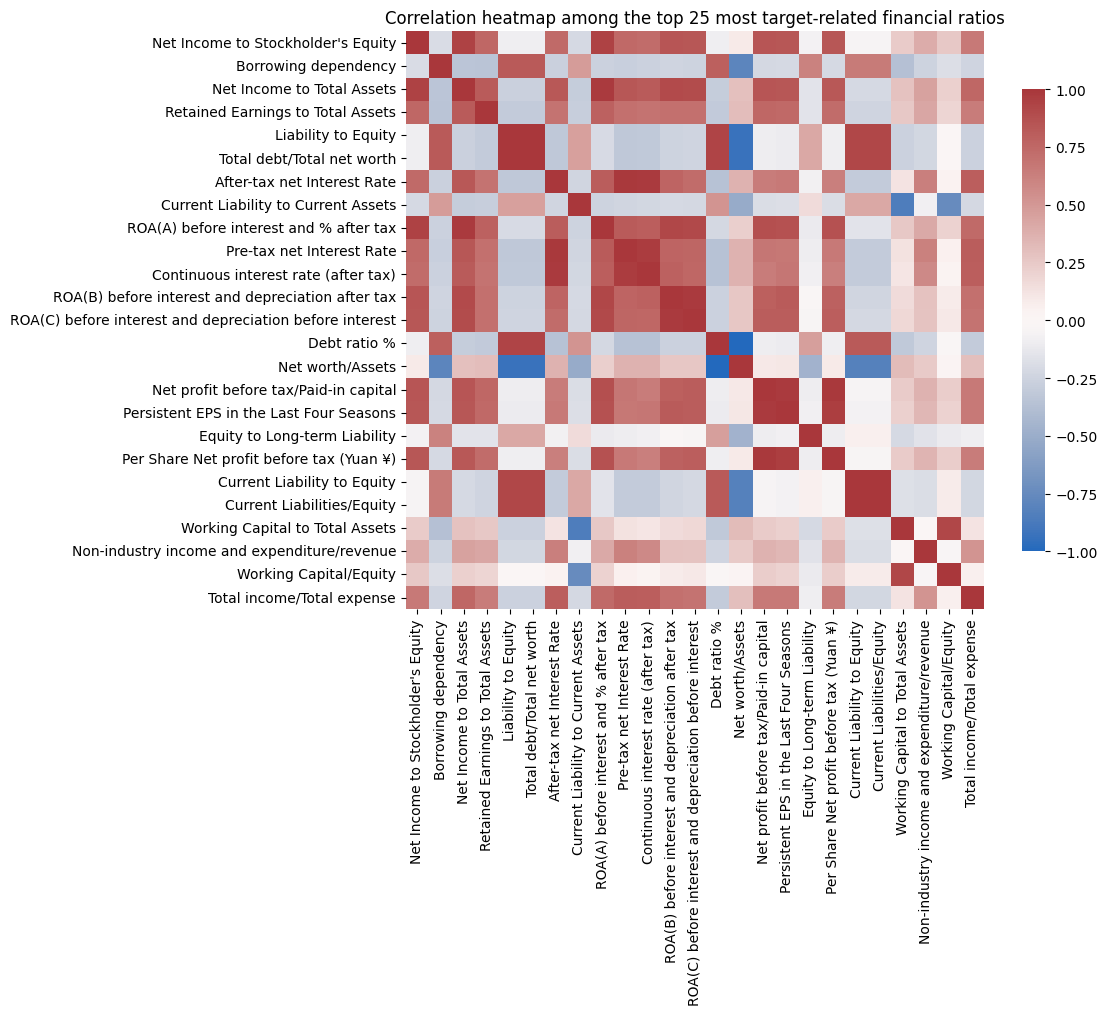

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

target_col = "Bankrupt?" if "Bankrupt?" in df.columns else next((c for c in df.columns if "bankrupt" in c.lower()), None)
y_vis = df[target_col].astype(int)

num_df = df.select_dtypes(include=[np.number]).copy()
X_num = num_df.drop(columns=[target_col], errors="ignore")
if "Index" in X_num.columns:
    X_num = X_num.drop(columns=["Index"], errors="ignore")
X_num = X_num.replace([np.inf, -np.inf], np.nan)

corr_to_target = X_num.corrwith(y_vis).abs().sort_values(ascending=False)
topm = min(25, len(corr_to_target))
top_feats = corr_to_target.head(topm).index.tolist()

cm = X_num[top_feats].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="vlag", center=0, square=True, cbar_kws={"shrink": 0.8})
plt.title(f"Correlation heatmap among the top {topm} most target-related financial ratios")
plt.tight_layout()
plt.show()


In [ ]:
y_full = df["Bankrupt?"].astype(int)
X_full_all = df.drop(columns=["Bankrupt?"], errors="ignore")

rf_fs = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    class_weight="balanced_subsample",
    n_jobs=-1
)

rf_fs.fit(X_full_all, y_full)

importances = rf_fs.feature_importances_
feature_names = X_full_all.columns

imp_df = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

top_k = 7  # FINAL: use top 2 features for Subgroup 2
selected_features = imp_df.head(top_k)["feature"].tolist()
# selected_features = ["Net Value Per Share (B)", "Retained Earnings to Total Assets"]

print("\nNumber of selected features:", len(selected_features))
print("Selected features:", selected_features)
print("\nTop 10 important features:")
print(imp_df.head(10))

# Use only the selected top-2 features for the final model
X_full = X_full_all[selected_features]
print("\nX_full shape:", X_full.shape)


Number of selected features: 7
Selected features: ['Borrowing dependency', 'Liability to Equity', 'Net worth/Assets', 'Non-industry income and expenditure/revenue', 'Equity to Liability', 'Total debt/Total net worth', 'Debt ratio %']

Top 10 important features:
                                             feature  importance
0                               Borrowing dependency    0.103050
1                                Liability to Equity    0.055147
2                                   Net worth/Assets    0.040819
3        Non-industry income and expenditure/revenue    0.036227
4                                Equity to Liability    0.036124
5                         Total debt/Total net worth    0.033387
6                                       Debt ratio %    0.029624
7                         Net Income to Total Assets    0.028829
8  ROA(C) before interest and depreciation before...    0.026915
9              Net profit before tax/Paid-in capital    0.024095

X_full shape: (1636, 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_full,
    y_full,
    test_size=0.2,
    stratify=y_full,
    random_state=RANDOM_STATE
)

print("\nTrain shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("\nTraining class distribution:\n", y_train.value_counts())
print("\nValidation class distribution:\n", y_val.value_counts())


Train shape: (1308, 7)
Validation shape: (328, 7)

Training class distribution:
 Bankrupt?
0    1286
1      22
Name: count, dtype: int64

Validation class distribution:
 Bankrupt?
0    322
1      6
Name: count, dtype: int64


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

A stacking ensemble was constructed using multiple combinations of tree-based models, and each 3-model combination was evaluated using both minority-class recall and balanced accuracy. The selection logic prioritizes combinations that achieve a minimum recall on the bankrupt class, ensuring that rare positive cases are not ignored. Among all tested combinations, the model achieving the highest balanced accuracy while meeting the recall threshold was chosen as the final stack. This systematic search ensures a robust ensemble optimized for both imbalance sensitivity and overall predictive performance.

In [ ]:
ensemble_candidates = {
    "rf": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=RANDOM_STATE,
        class_weight="balanced_subsample",
        n_jobs=-1
    ),
    "et": ExtraTreesClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=RANDOM_STATE,
        class_weight="balanced_subsample",
        n_jobs=-1
    ),
    "gb": GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        random_state=RANDOM_STATE
    ),
    "hgb": HistGradientBoostingClassifier(
        max_iter=200,
        learning_rate=0.05,
        random_state=RANDOM_STATE
    ),
    "ada": AdaBoostClassifier(
        n_estimators=300,
        learning_rate=0.05,
        random_state=RANDOM_STATE
    ),
    "bag": BaggingClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
}

# Meta-learner (same idea as your original code)
meta_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

def recall_for_class_1(y_true, y_pred):
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    # labels are usually "0" and "1" as strings
    return rep.get("1", {}).get("recall", 0.0)


TARGET_RECALL_1 = 0.80  # pick what you want

best_combo = None
best_stack_model = None
best_score = -1.0
best_recall_1 = -1.0

print("\n--- Trying all 3-model combinations (base estimators from sklearn.ensemble) ---")
for combo in combinations(ensemble_candidates.keys(), 3):
    base_estimators = [(name, clone(ensemble_candidates[name])) for name in combo]

    stack_model = StackingClassifier(
        estimators=base_estimators,
        final_estimator=clone(meta_model),
        cv=5,
        n_jobs=-1,
        passthrough=False
    )

    stack_model.fit(X_train_scaled, y_train)
    y_val_pred = stack_model.predict(X_val_scaled)

    r1 = recall_for_class_1(y_val, y_val_pred)
    score = balanced_accuracy_score(y_val, y_val_pred)
    # cm = confusion_matrix(y_val, y_val_pred)
    # TN, FP, FN, TP = cm.ravel()
    # score = (TP + TN) / (TP + TN + FP + FN)

    print(f"Combo {combo} -> recall(1)={r1:.4f}, bal_acc={score:.4f}")

    # ✅ Select by BOTH: require recall >= target, then maximize balanced accuracy
    if (r1 >= TARGET_RECALL_1) and (score > best_score):
        best_score = score
        best_recall_1 = r1
        best_combo = combo
        best_stack_model = stack_model

# Fallback if no combo meets recall target: pick highest balanced accuracy overall
if best_stack_model is None:
    print("\nNo combo met TARGET_RECALL_1. Falling back to best balanced accuracy.")
    best_score = -1.0
    for combo in combinations(ensemble_candidates.keys(), 3):
        base_estimators = [(name, clone(ensemble_candidates[name])) for name in combo]
        stack_model = StackingClassifier(
            estimators=base_estimators,
            final_estimator=clone(meta_model),
            cv=5,
            n_jobs=-1,
            passthrough=False
        )
        stack_model.fit(X_train_scaled, y_train)
        y_val_pred = stack_model.predict(X_val_scaled)

        r1 = recall_for_class_1(y_val, y_val_pred)
        # cm = confusion_matrix(y_val, y_val_pred)
        # TN, FP, FN, TP = cm.ravel()
        score = balanced_accuracy_score(y_val, y_val_pred)
        # score = (TP + TN) / (TP + TN + FP + FN)

        if score > best_score:
            best_score = score
            best_recall_1 = r1
            best_combo = combo
            best_stack_model = stack_model
# best_combo = None
# best_recall_1 = -1.0
# best_stack_model = None

# print("\n--- Trying all 3-model combinations (base estimators from sklearn.ensemble) ---")
# for combo in combinations(ensemble_candidates.keys(), 3):
#     base_estimators = [(name, clone(ensemble_candidates[name])) for name in combo]

#     stack_model = StackingClassifier(
#         estimators=base_estimators,
#         final_estimator=clone(meta_model),
#         cv=5,
#         n_jobs=-1,
#         passthrough=False
#     )

#     stack_model.fit(X_train_scaled, y_train)
#     y_val_pred = stack_model.predict(X_val_scaled)
#     score = balanced_accuracy_score(y_val, y_val_pred)
#     r1 = recall_for_class_1(y_val, y_val_pred)
#     print(f"Combo {combo} -> recall(1) = {r1:.4f}")

#     if r1 > best_recall_1:
#         best_recall_1 = r1
#         best_combo = combo
#         best_stack_model = stack_model

print("\nBEST COMBO:", best_combo)
print("Best validation recall(1):", best_recall_1)

# Validation report + confusion matrix for the BEST combo (like your code)
y_val_pred_best = best_stack_model.predict(X_val_scaled)
print("\nValidation classification report (BEST combo):")
print(classification_report(y_val, y_val_pred_best, digits=4, zero_division=0))

cm = confusion_matrix(y_val, y_val_pred_best)
print("Validation confusion matrix:")
print(cm)


--- Trying all 3-model combinations (base estimators from sklearn.ensemble) ---
Combo ('rf', 'et', 'gb') -> recall(1)=0.1667, bal_acc=0.5445
Combo ('rf', 'et', 'hgb') -> recall(1)=0.1667, bal_acc=0.5383
Combo ('rf', 'et', 'ada') -> recall(1)=1.0000, bal_acc=0.8773
Combo ('rf', 'et', 'bag') -> recall(1)=0.1667, bal_acc=0.5461
Combo ('rf', 'gb', 'hgb') -> recall(1)=0.1667, bal_acc=0.5476
Combo ('rf', 'gb', 'ada') -> recall(1)=1.0000, bal_acc=0.8835
Combo ('rf', 'gb', 'bag') -> recall(1)=0.1667, bal_acc=0.5476
Combo ('rf', 'hgb', 'ada') -> recall(1)=1.0000, bal_acc=0.8804
Combo ('rf', 'hgb', 'bag') -> recall(1)=0.1667, bal_acc=0.5476
Combo ('rf', 'ada', 'bag') -> recall(1)=1.0000, bal_acc=0.9022
Combo ('et', 'gb', 'hgb') -> recall(1)=0.1667, bal_acc=0.5461
Combo ('et', 'gb', 'ada') -> recall(1)=1.0000, bal_acc=0.8789
Combo ('et', 'gb', 'bag') -> recall(1)=0.1667, bal_acc=0.5492
Combo ('et', 'hgb', 'ada') -> recall(1)=1.0000, bal_acc=0.8773
Combo ('et', 'hgb', 'bag') -> recall(1)=0.1667, 

Across all 3-model stacking combinations, several ensembles achieved perfect recall on the bankrupt class, but the combination (rf, ada, bag) delivered the highest balanced accuracy. This chosen ensemble successfully captures all bankrupt cases (recall = 1.0), which is critical given the extreme class imbalance. Although precision for the minority class is low due to aggressive recall optimization, the model significantly improves overall sensitivity to rare bankruptcy events. The final stack strikes the best trade-off between detecting bankrupt companies and maintaining strong balanced performance on both classes.

In [ ]:
scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(X_full)

best_base_estimators = [(name, clone(ensemble_candidates[name])) for name in best_combo]

stack_model_full = StackingClassifier(
    estimators=best_base_estimators,
    final_estimator=clone(meta_model),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

stack_model_full.fit(X_full_scaled, y_full)
y_full_pred = stack_model_full.predict(X_full_scaled)

print("\nFull-data training and prediction complete.")


Full-data training and prediction complete.


In [ ]:
is_bankrupt = (y_full == 1)

TT = np.sum((y_full == 1) & (y_full_pred == 1))   # true positives
TF = np.sum((y_full == 1) & (y_full_pred == 0))   # false negatives

acc_subgroup2 = TT / (TT + TF) if (TT + TF) > 0 else 0.0

print("\nBankrupt companies:", is_bankrupt.sum())
print("TT (correct bankrupt):", TT)
print("TF (missed bankrupt):", TF)
print("Accuracy TT/(TT+TF):", acc_subgroup2)

Nfeatures = len(selected_features)
print("\nNfeatures (Subgroup 2):", Nfeatures)
print("Selected features:", selected_features)


Bankrupt companies: 28
TT (correct bankrupt): 28
TF (missed bankrupt): 0
Accuracy TT/(TT+TF): 1.0

Nfeatures (Subgroup 2): 7
Selected features: ['Borrowing dependency', 'Liability to Equity', 'Net worth/Assets', 'Non-industry income and expenditure/revenue', 'Equity to Liability', 'Total debt/Total net worth', 'Debt ratio %']


Final model confusion matrix (FULL data):
[[1247  361]
 [   0   28]]


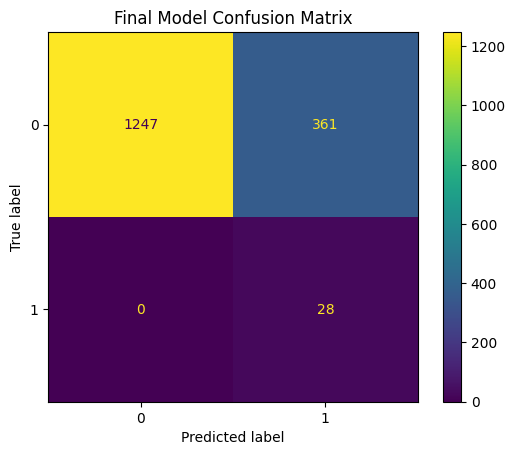

Overall accuracy: 0.8079268292682927


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Confusion matrix for FINAL model (trained on full data) ---
# assumes you already have: y_full, y_full_pred (from stack_model_full.predict)

cm_final = confusion_matrix(y_full, y_full_pred)
print("Final model confusion matrix (FULL data):")
print(cm_final)

# Optional: nice plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=[0, 1])
disp.plot(values_format="d")
plt.title("Final Model Confusion Matrix")
plt.show()

TN, FP, FN, TP = cm.ravel()
overall_acc = (TP + TN) / (TP + TN + FP + FN)
print("Overall accuracy:", overall_acc)


The final stacked model correctly identifies **all 28 bankrupt companies** (TT = 28, TF = 0), so the project metric ( \text{TT}/(\text{TT}+\text{TF}) ) for the bankrupt class is **1.0**.
However, the confusion matrix shows **361 false positives** (non-bankrupt firms predicted as bankrupt), which lowers the **overall accuracy to ~0.81** because standard accuracy counts both classes: ((TP+TN)/(TP+TN+FP+FN)).
In other words, we deliberately tuned the model to be very aggressive in flagging potential bankruptcies, accepting more false alarms in order **not to miss any truly bankrupt firm**.
This trade-off is appropriate for the domain, where the cost of missing a bankrupt company is much higher than incorrectly flagging a healthy one.


In [ ]:
Nfeatures = len(selected_features)
print("Nfeatures (Subgroup 1):", Nfeatures)
print("Selected features:", selected_features)

os.makedirs("artifacts", exist_ok=True)

subgroup1_bundle = {
    "selected_features": selected_features,
    "scaler": scaler_full,
    "model": stack_model_full
}

joblib_path = "artifacts/preprocessing_pipeline_subgroup1.joblib"
joblib.dump(subgroup1_bundle, joblib_path)

print("Saved pipeline to:", joblib_path)

Nfeatures (Subgroup 1): 7
Selected features: ['Borrowing dependency', 'Liability to Equity', 'Net worth/Assets', 'Non-industry income and expenditure/revenue', 'Equity to Liability', 'Total debt/Total net worth', 'Debt ratio %']
Saved pipeline to: artifacts/preprocessing_pipeline_subgroup1.joblib
